In [ ]:
import torch, torchvision, diffusers, transformers
print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)
print("diffusers:", diffusers.__version__)
print("transformers:", transformers.__version__)


torch: 2.4.1+cu121
torchvision: 0.19.1+cu121
diffusers: 0.30.0
transformers: 4.44.2


In [ ]:
!pip -q install --upgrade torch==2.4.1 torchvision==0.19.1 \
  diffusers==0.30.0 transformers==4.44.2 accelerate==1.0.1 \
  datasets==3.0.1 torchmetrics==1.4.1 pillow==10.4.0 \
  safetensors==0.4.5 tqdm==4.66.5 scikit-image==0.24.0 \
  pandas==2.2.2 numpy==1.26.4


In [ ]:
import os, math, random, json, time, shutil
from pathlib import Path
from dataclasses import dataclass

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader

from PIL import Image
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from datasets import load_dataset
from torchvision import transforms
from torchvision.models.inception import inception_v3

from diffusers import (
    StableDiffusionPipeline,
    DDPMScheduler,
)
from diffusers.models.attention_processor import LoRAAttnProcessor
from diffusers.optimization import get_cosine_schedule_with_warmup

from transformers import CLIPModel, CLIPProcessor, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [ ]:
import random, numpy as np
random.seed(0); np.random.seed(0); torch.manual_seed(0)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(0)


In [ ]:
from torchvision.models import inception_v3


In [ ]:
# ============================
# Config
# ============================
@dataclass
class Config:
    base_model: str = "runwayml/stable-diffusion-v1-5"
    dataset_name: str = "huggan/wikiart"   # WikiArt on HF
    dataset_split: str = "train"
    output_dir: str = "sd15_wikiart_lora"
    image_size: int = 512
    train_batch_size: int = 2              # bump if VRAM allows
    gradient_accumulation_steps: int = 4   # effective batch size = 2*4 = 8
    lr: float = 1e-4
    max_train_steps: int = 2000            # increase for better results (e.g. 10k+)
    warmup_steps: int = 100
    mixed_precision: str = "fp16"          # "no", "fp16", or "bf16"
    lora_rank: int = 8
    lora_alpha: int = 16
    ema_decay: float = 0.0                 # disabled for simplicity
    save_every: int = 500                  # save LoRA weights every N steps
    seed: int = 42
    num_workers: int = 4
    # Inference
    num_inference_steps: int = 35
    guidance_scale: float = 7.5
    samples_per_prompt: int = 2
    # Evaluation
    eval_num_images: int = 50              # for IS computation (>= 50 recommended)
    clip_model_name: str = "openai/clip-vit-large-patch14"  # for CLIP similarity

cfg = Config()
os.makedirs(cfg.output_dir, exist_ok=True)
torch.manual_seed(cfg.seed)
np.random.seed(cfg.seed)
random.seed(cfg.seed)


In [ ]:
print(cfg)


Config(base_model='runwayml/stable-diffusion-v1-5', dataset_name='huggan/wikiart', dataset_split='train', output_dir='sd15_wikiart_lora', image_size=512, train_batch_size=2, gradient_accumulation_steps=4, lr=0.0001, max_train_steps=2000, warmup_steps=100, mixed_precision='fp16', lora_rank=8, lora_alpha=16, ema_decay=0.0, save_every=500, seed=42, num_workers=4, num_inference_steps=35, guidance_scale=7.5, samples_per_prompt=2, eval_num_images=50, clip_model_name='openai/clip-vit-large-patch14')


In [ ]:
# ============================
# Config
# ============================
@dataclass
class Config:
    base_model: str = "runwayml/stable-diffusion-v1-5"
    dataset_name: str = "huggan/wikiart"   # WikiArt on HF
    dataset_split: str = "train"
    output_dir: str = "sd15_wikiart_lora"
    image_size: int = 512
    train_batch_size: int = 2              # bump if VRAM allows
    gradient_accumulation_steps: int = 4   # effective batch size = 2*4 = 8
    lr: float = 1e-4
    max_train_steps: int = 2000            # increase for better results (e.g. 10k+)
    warmup_steps: int = 100
    mixed_precision: str = "fp16"          # "no", "fp16", or "bf16"
    lora_rank: int = 8
    lora_alpha: int = 16
    ema_decay: float = 0.0                 # disabled for simplicity
    save_every: int = 500                  # save LoRA weights every N steps
    seed: int = 42
    num_workers: int = 4
    # Inference
    num_inference_steps: int = 35
    guidance_scale: float = 7.5
    samples_per_prompt: int = 2
    # Evaluation
    eval_num_images: int = 50              # for IS computation (>= 50 recommended)
    clip_model_name: str = "openai/clip-vit-large-patch14"  # for CLIP similarity

cfg = Config()
os.makedirs(cfg.output_dir, exist_ok=True)
torch.manual_seed(cfg.seed)
np.random.seed(cfg.seed)
random.seed(cfg.seed)


In [ ]:
print(cfg)


Config(base_model='runwayml/stable-diffusion-v1-5', dataset_name='huggan/wikiart', dataset_split='train', output_dir='sd15_wikiart_lora', image_size=512, train_batch_size=2, gradient_accumulation_steps=4, lr=0.0001, max_train_steps=2000, warmup_steps=100, mixed_precision='fp16', lora_rank=8, lora_alpha=16, ema_decay=0.0, save_every=500, seed=42, num_workers=4, num_inference_steps=35, guidance_scale=7.5, samples_per_prompt=2, eval_num_images=50, clip_model_name='openai/clip-vit-large-patch14')


In [ ]:
# ============================
# Load / Prepare Dataset (WikiArt)
# Build captions from metadata to supervise text conditioning.
# ============================

dataset = load_dataset(cfg.dataset_name, split=cfg.dataset_split)

# Inspect a few columns
print(dataset.column_names)
print(dataset[0].keys())
# Typical fields: 'image', 'genre', 'style', 'artist', 'title', 'date', ...

# Compose a caption template using available metadata
def make_caption(row):
    # Robustly build a caption string
    title = row.get("title") or ""
    artist = row.get("artist") or ""
    style = row.get("style") or ""
    genre = row.get("genre") or ""
    parts = []
    if genre: parts.append(f"{genre} painting")
    else: parts.append("painting")
    if style: parts.append(f"in {style} style")
    if artist: parts.append(f"by {artist}")
    if title: parts.append(f"titled \"{title}\"")
    return ", ".join(parts)

# Transform pipeline to 512x512
train_tfms = transforms.Compose([
    transforms.Resize(cfg.image_size, interpolation=transforms.InterpolationMode.BILINEAR, antialias=True),
    transforms.CenterCrop(cfg.image_size),
    transforms.ToTensor(),                       # [0,1]
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # instead of [0.5], [0.5]
           # to [-1,1]
])

class WikiArtDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset):
        self.ds = hf_dataset

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        row = self.ds[idx]
        image: Image.Image = row["image"].convert("RGB")
        pixel_values = train_tfms(image)
        caption = make_caption(row)
        return {"pixel_values": pixel_values, "caption": caption}

train_ds = WikiArtDataset(dataset)
len(train_ds), train_ds[0]["pixel_values"].shape, train_ds[0]["caption"][:120]


Generating train split: 100%|██████████| 81444/81444 [00:43<00:00, 1880.87 examples/s]


['image', 'artist', 'genre', 'style']
dict_keys(['image', 'artist', 'genre', 'style'])


(81444, torch.Size([3, 512, 512]), '4 painting, in 21 style, by 22')

In [ ]:
# Map ClassLabel indices to readable strings and build captions

from torchvision import transforms
from PIL import Image

# Reuse image_size=512; make a transform for SD input format: RGB → 512, center-crop, [-1,1]
IMAGE_SIZE = 512
train_tfms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE, interpolation=transforms.InterpolationMode.BILINEAR, antialias=True),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),                  # [0,1]
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
     # → [-1,1]
])

def idx2name(hfds, field, value):
    feat = hfds.features.get(field, None)
    if feat is not None and hasattr(feat, "int2str"):
        try:
            return feat.int2str(int(value))
        except Exception:
            return str(value)
    return str(value)

def make_caption(row, hfds):
    # Build a natural caption from available metadata
    title  = row.get("title", "")
    artist = idx2name(hfds, "artist", row.get("artist", ""))
    style  = idx2name(hfds, "style",  row.get("style",  ""))
    genre  = idx2name(hfds, "genre",  row.get("genre",  ""))

    parts = []
    if genre: parts.append(f"{genre} painting")
    else:     parts.append("painting")
    if style: parts.append(f"in {style} style")
    if artist:parts.append(f"by {artist}")
    if title: parts.append(f'titled "{title}"')
    return ", ".join(parts)

class WikiArtDS(torch.utils.data.Dataset):
    def __init__(self, hfds, transform):
        self.hfds = hfds
        self.tf = transform

    def __len__(self):
        return len(self.hfds)

    def __getitem__(self, idx):
        row = self.hfds[idx]
        image = row["image"].convert("RGB")
        pixel_values = self.tf(image)
        caption = make_caption(row, self.hfds)
        return {"pixel_values": pixel_values, "caption": caption}

# Build full dataset wrapper
proc_full_ds = WikiArtDS(dataset, train_tfms)

# quick check
s = proc_full_ds[0]
(len(proc_full_ds), s["pixel_values"].shape, s["caption"])


(81444,
 torch.Size([3, 512, 512]),
 'landscape painting, in Realism style, by vincent-van-gogh')

In [ ]:
# Use a small validation split (e.g., 5%)
split = dataset.train_test_split(test_size=0.05, seed=42)
train_hfds, val_hfds = split["train"], split["test"]

train_ds = WikiArtDS(train_hfds, train_tfms)
val_ds   = WikiArtDS(val_hfds,   train_tfms)

len(train_ds), len(val_ds), train_ds[0]["caption"]


(77371, 4073, 'landscape painting, in Cubism style, by Unknown Artist')

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 2    # adjust per VRAM
NUM_WORKERS = 4

def collate_fn(examples):
    pixel_values = torch.stack([ex["pixel_values"] for ex in examples])  # [B,3,512,512]
    captions = [ex["caption"] for ex in examples]
    tokens = tokenizer(
        captions,
        padding="max_length",
        truncation=True,
        max_length=tokenizer.model_max_length,
        return_tensors="pt"
    )
    return {
        "pixel_values": pixel_values,           # float in [-1,1]
        "input_ids": tokens.input_ids,          # [B, seq]
        "attention_mask": tokens.attention_mask # [B, seq]
    }

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=False,
    collate_fn=collate_fn
)

len(train_loader), len(val_loader)


(38685, 2037)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(cfg.clip_model_name)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pixel_values: torch.Size([2, 3, 512, 512]) torch.float32 min=-0.992 max=1.000
input_ids: torch.Size([2, 77]) attention_mask: torch.Size([2, 77])


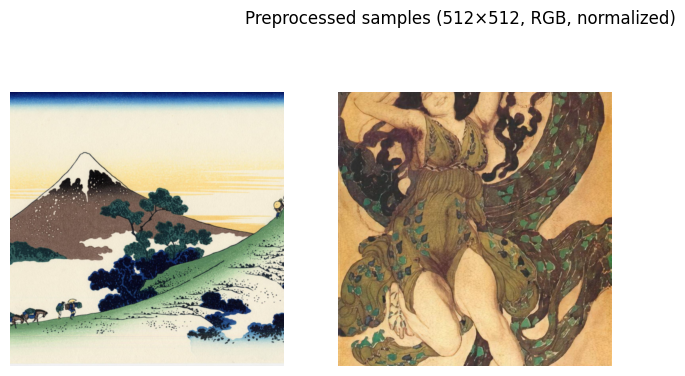

In [ ]:
!pip install matplotlib
import matplotlib.pyplot as plt
# Sanity: pull one batch and inspect shapes & ranges
batch = next(iter(train_loader))
pv = batch["pixel_values"]
print("pixel_values:", pv.shape, pv.dtype, f"min={pv.min().item():.3f}", f"max={pv.max().item():.3f}")
print("input_ids:", batch["input_ids"].shape, "attention_mask:", batch["attention_mask"].shape)

# Optional: visualize (quick inverse normalize) a few images to ensure 512x512 + RGB is correct
import matplotlib.pyplot as plt

def unnorm(x):
    # inverse of Normalize([0.5],[0.5]) → back to [0,1]
    return (x * 0.5 + 0.5).clamp(0,1)

grid_count = min(6, pv.size(0))
plt.figure(figsize=(12, 8))
for i in range(grid_count):
    plt.subplot(2, 3, i+1)
    img = unnorm(pv[i]).permute(1,2,0).cpu().numpy()
    plt.imshow(img)
    plt.axis("off")
plt.suptitle("Preprocessed samples (512×512, RGB, normalized)")
plt.show()

In [ ]:
# ============================
# Attach LoRA to UNet using PEFT (version-agnostic & reliable)
# ============================
!pip -q install peft==0.12.0

from peft import LoraConfig, get_peft_model, TaskType

# 1) Freeze the base UNet
for p in unet.parameters():
    p.requires_grad_(False)

# 2) Define LoRA config targeting SD1.5 attention projection layers
peft_cfg = LoraConfig(
    r=cfg.lora_rank,
    lora_alpha=cfg.lora_alpha,
    lora_dropout=0.0,
    bias="none",
    target_modules=["to_q", "to_k", "to_v", "to_out.0"],
    task_type=TaskType.FEATURE_EXTRACTION,   # we’re adapting a feature extractor (UNet), not doing LM
)

# 3) Wrap the UNet with PEFT and expose LoRA params
unet_peft = get_peft_model(unet, peft_cfg)

# Make only LoRA params trainable
for name, p in unet_peft.named_parameters():
    if "lora_" in name:
        p.requires_grad_(True)

# IMPORTANT: put the wrapped model back into the pipeline
pipe.unet = unet_peft

# 4) Report trainables
trainable = sum(p.numel() for n, p in unet_peft.named_parameters() if p.requires_grad)
total = sum(p.numel() for p in unet_peft.parameters())
print(f"LoRA attached via PEFT. Trainable params: {trainable:,} / {total:,}")

# Show a few LoRA params to confirm
shown = 0
for name, p in unet_peft.named_parameters():
    if p.requires_grad and "lora_" in name:
        print("Sample LoRA param:", name, tuple(p.shape))
        shown += 1
        if shown >= 5:
            break

# Keep correct modes
text_encoder.eval(); vae.eval(); pipe.unet.train()


LoRA attached via PEFT. Trainable params: 1,594,368 / 861,115,332
Sample LoRA param: base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora_A.default.weight (8, 320)
Sample LoRA param: base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora_B.default.weight (320, 8)
Sample LoRA param: base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.lora_A.default.weight (8, 320)
Sample LoRA param: base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.lora_B.default.weight (320, 8)
Sample LoRA param: base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.lora_A.default.weight (8, 320)


PeftModelForFeatureExtraction(
  (base_model): LoraModel(
    (model): UNet2DConditionModel(
      (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (time_proj): Timesteps()
      (time_embedding): TimestepEmbedding(
        (linear_1): Linear(in_features=320, out_features=1280, bias=True)
        (act): SiLU()
        (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (down_blocks): ModuleList(
        (0): CrossAttnDownBlock2D(
          (attentions): ModuleList(
            (0-1): 2 x Transformer2DModel(
              (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
              (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
              (transformer_blocks): ModuleList(
                (0): BasicTransformerBlock(
                  (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
                  (attn1): Attention(
                    (to_q): lora.Linear(
                      (base_la

In [ ]:
# ============================
# Reset: load a clean SD1.5 pipeline and attach ONLY PEFT LoRA
# ============================
from diffusers import StableDiffusionPipeline, DDPMScheduler
from peft import LoraConfig, get_peft_model, TaskType

# 1) Fresh pipeline (no legacy processors carried over)
pipe = StableDiffusionPipeline.from_pretrained(
    cfg.base_model,
    torch_dtype=(torch.float16 if (device == "cuda" and cfg.mixed_precision == "fp16") else torch.float32),
).to(device)
pipe.safety_checker = None

text_encoder = pipe.text_encoder
vae          = pipe.vae
unet         = pipe.unet
noise_scheduler = DDPMScheduler.from_pretrained(cfg.base_model, subfolder="scheduler")

# 2) Freeze base UNet
for p in unet.parameters():
    p.requires_grad_(False)

# 3) Attach PEFT LoRA (ONLY) to UNet attention projections
peft_cfg = LoraConfig(
    r=cfg.lora_rank,
    lora_alpha=cfg.lora_alpha,
    lora_dropout=0.0,
    bias="none",
    target_modules=["to_q", "to_k", "to_v", "to_out.0"],
    task_type=TaskType.FEATURE_EXTRACTION,
)
unet_peft = get_peft_model(unet, peft_cfg)

# 4) Make only LoRA params trainable and install back into the pipeline
for name, p in unet_peft.named_parameters():
    p.requires_grad_(("lora_" in name))

pipe.unet = unet_peft

# 5) Sanity: count trainables and set core handle for training forward()
trainable = sum(p.numel() for p in pipe.unet.parameters() if p.requires_grad)
total     = sum(p.numel() for p in pipe.unet.parameters())
print(f"[RESET OK] PEFT-LoRA attached. Trainable params: {trainable:,} / {total:,}")

# Use this in the training forward call to avoid PEFT signature collisions
unet_core = getattr(pipe.unet, "base_model", pipe.unet)
print("Use `unet_core(sample=..., timestep=..., encoder_hidden_states=...)` in the loop.")


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  6.01it/s]


[RESET OK] PEFT-LoRA attached. Trainable params: 1,594,368 / 861,115,332
Use `unet_core(sample=..., timestep=..., encoder_hidden_states=...)` in the loop.


In [ ]:
# ============================
# Training loop (PEFT-LoRA on SD 1.5 — clean & stable)
# ============================
from torch.optim import AdamW
from diffusers.optimization import get_cosine_schedule_with_warmup
import torch.nn.functional as F
from pathlib import Path
import time, os

# Paths for saving LoRA checkpoints
run_dir = Path(cfg.output_dir) / time.strftime("%Y%m%d_%H%M%S")
ckpt_dir = run_dir / "lora_ckpts"
ckpt_dir.mkdir(parents=True, exist_ok=True)
print("Run dir:", run_dir)

# Optimizer, scheduler, scaler
lora_params = [p for p in pipe.unet.parameters() if p.requires_grad]
optimizer = AdamW(lora_params, lr=cfg.lr, weight_decay=1e-2)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=cfg.warmup_steps,
    num_training_steps=cfg.max_train_steps
)
use_fp16 = (device == "cuda" and cfg.mixed_precision == "fp16")
scaler = torch.amp.GradScaler('cuda', enabled=use_fp16)
latent_scale = 0.18215

def save_lora(step: int):
    save_path = ckpt_dir / f"step_{step:06d}"
    save_path.mkdir(parents=True, exist_ok=True)
    pipe.unet.save_pretrained(save_path.as_posix())
    print(f"[Checkpoint] Saved LoRA at step {step} -> {save_path}")

pipe.unet.train(); text_encoder.eval(); vae.eval()
global_step = 0
accum = cfg.gradient_accumulation_steps
print("Starting training...")

# use unet_core (the true model under PEFT)
unet_core = getattr(pipe.unet, "base_model", pipe.unet)

while global_step < cfg.max_train_steps:
    for batch in train_loader:
        if global_step >= cfg.max_train_steps:
            break

        pixel_values = batch["pixel_values"].to(device, non_blocking=True)
        input_ids    = batch["input_ids"].to(device, non_blocking=True)

        # Encode images to latents (ensure dtype matches VAE)
        with torch.no_grad():
            img_dtype = torch.float16 if use_fp16 else torch.float32
            latents = vae.encode(pixel_values.to(dtype=img_dtype)).latent_dist.sample() * latent_scale

        noise = torch.randn_like(latents)
        bsz = latents.shape[0]
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps,
            (bsz,), device=device, dtype=torch.long
        )
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        with torch.no_grad():
            encoder_hidden_states = text_encoder(input_ids)[0]

        # Forward UNet safely (avoid PEFT input_ids signature issue)
        with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=use_fp16):
            out = unet_core(
                sample=noisy_latents,
                timestep=timesteps,
                encoder_hidden_states=encoder_hidden_states
            )
            noise_pred = out.sample
            loss = F.mse_loss(noise_pred.float(), noise.float(), reduction="mean")

        scaler.scale(loss / accum).backward()

        if (global_step + 1) % accum == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            lr_scheduler.step()

        if global_step % 100 == 0:
            print(f"step={global_step:05d} loss={loss.item():.4f} lr={optimizer.param_groups[0]['lr']:.2e}")

        if (global_step % cfg.save_every == 0) and global_step > 0:
            save_lora(global_step)

        global_step += 1

save_lora(global_step)
print("Training complete.")
print("LoRA checkpoints:", ckpt_dir)


Run dir: sd15_wikiart_lora/20251122_022950
Starting training...
step=00000 loss=0.0351 lr=0.00e+00
step=00100 loss=0.3963 lr=2.50e-05
step=00200 loss=0.2311 lr=5.00e-05
step=00300 loss=0.0280 lr=7.50e-05
step=00400 loss=0.3105 lr=1.00e-04
step=00500 loss=0.0914 lr=1.00e-04
[Checkpoint] Saved LoRA at step 500 -> sd15_wikiart_lora/20251122_022950/lora_ckpts/step_000500
step=00600 loss=0.0658 lr=9.98e-05
step=00700 loss=0.0745 lr=9.96e-05
step=00800 loss=0.0457 lr=9.93e-05
step=00900 loss=0.1506 lr=9.89e-05
step=01000 loss=0.0388 lr=9.85e-05
[Checkpoint] Saved LoRA at step 1000 -> sd15_wikiart_lora/20251122_022950/lora_ckpts/step_001000
step=01100 loss=0.1994 lr=9.79e-05
step=01200 loss=0.1252 lr=9.73e-05
step=01300 loss=0.5273 lr=9.66e-05
step=01400 loss=0.2167 lr=9.58e-05
step=01500 loss=0.4505 lr=9.49e-05
[Checkpoint] Saved LoRA at step 1500 -> sd15_wikiart_lora/20251122_022950/lora_ckpts/step_001500
step=01600 loss=0.2164 lr=9.40e-05
step=01700 loss=0.0502 lr=9.30e-05
step=01800 loss=

In [ ]:
cfg.prompts = [
    "Colorful abstract painting",
    "A cat wearing a crown",
    "Impressionist riverside garden with water lilies",
    "Surreal melting clocks in a desert landscape",
    "Baroque still life with fruits and dramatic lighting"
]


In [ ]:
# ============================
# Inference setup + generation (Baseline vs Finetuned)
# ============================
from pathlib import Path
import pandas as pd
from PIL import Image
from peft import PeftModel

# 0) Ensure prompts exist (fallback if not defined in cfg)
if not hasattr(cfg, "prompts") or cfg.prompts is None:
    cfg.prompts = [
    "Colorful abstract painting",
    "A cat wearing a crown",
    "Impressionist riverside garden with water lilies",
    "Surreal melting clocks in a desert landscape",
    "Baroque still life with fruits and dramatic lighting"
]

# 1) Clean baseline pipeline (no LoRA)
pipe_base = StableDiffusionPipeline.from_pretrained(
    cfg.base_model,
    torch_dtype=(torch.float16 if (device == "cuda" and cfg.mixed_precision == "fp16") else torch.float32),
).to(device)
pipe_base.safety_checker = None

# 2) Finetuned pipeline: find latest LoRA checkpoint, load, and MERGE to avoid PEFT signature clashes
#    (search anywhere under cfg.output_dir for step_* folders)
root_out = Path(cfg.output_dir)
lora_steps = sorted(root_out.glob("**/step_*"))
if not lora_steps:
    raise FileNotFoundError(f"No LoRA checkpoints found under {root_out.resolve()}")
latest = lora_steps[-1]
print("Using LoRA checkpoint:", latest)

pipe_ft = StableDiffusionPipeline.from_pretrained(
    cfg.base_model,
    torch_dtype=(torch.float16 if (device == "cuda" and cfg.mixed_precision == "fp16") else torch.float32),
).to(device)
pipe_ft.safety_checker = None

# Load LoRA via PEFT, then merge into plain UNet (no PEFT wrapper at inference)
peft_unet = PeftModel.from_pretrained(pipe_ft.unet, latest.as_posix())
pipe_ft.unet = peft_unet.merge_and_unload()
pipe_ft.unet.eval()
print("Merged LoRA successfully; ready for inference.")

# 3) Generation helper
def generate_batch(pipe, model_tag, out_dir: Path, prompts, seeds, guidance, steps, image_size):
    out_dir.mkdir(parents=True, exist_ok=True)
    rows = []
    for i, ptxt in enumerate(prompts):
        for s in seeds:
            gen = torch.Generator(device=device).manual_seed(s)
            with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=(device=="cuda" and cfg.mixed_precision=="fp16")):
                img = pipe(
                    ptxt,
                    num_inference_steps=steps,
                    guidance_scale=guidance,
                    generator=gen,
                    height=image_size, width=image_size,
                ).images[0]
            fn = out_dir / f"{model_tag}_p{i}_seed{s}.png"
            img.save(fn)
            rows.append({"model": model_tag, "prompt_id": i, "prompt": ptxt, "seed": s, "path": str(fn)})
    df = pd.DataFrame(rows)
    df.to_csv(out_dir / "gen_log.csv", index=False)
    print(f"{model_tag}: saved {len(df)} images to {out_dir}")
    return df

# 4) Run generations for both models
RUN_GEN = (Path(cfg.output_dir) / "eval_generations")
BASE_DIR = RUN_GEN / "baseline_pretrained"
FT_DIR   = RUN_GEN / "finetuned_lora"

SEEDS = list(range(10))  # 10 seeds per prompt => 5*10=50 images per model

df_base = generate_batch(
    pipe_base, "baseline", BASE_DIR,
    cfg.prompts, SEEDS, cfg.guidance_scale, cfg.num_inference_steps, cfg.image_size
)
df_ft = generate_batch(
    pipe_ft, "finetuned", FT_DIR,
    cfg.prompts, SEEDS, cfg.guidance_scale, cfg.num_inference_steps, cfg.image_size
)

# 5) Save combined log
GEN_LOG = pd.concat([df_base, df_ft], ignore_index=True)
RUN_GEN.mkdir(parents=True, exist_ok=True)
GEN_LOG.to_csv(RUN_GEN / "gen_log_all.csv", index=False)
print("Combined generation log:", RUN_GEN / "gen_log_all.csv")


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.89it/s]


Using LoRA checkpoint: sd15_wikiart_lora/20251122_022950/lora_ckpts/step_002000


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.98it/s]


Merged LoRA successfully; ready for inference.


100%|██████████| 35/35 [00:01<00:00, 34.25it/s]


baseline: saved 50 images to sd15_wikiart_lora/eval_generations/baseline_pretrained


100%|██████████| 35/35 [00:00<00:00, 35.50it/s]


finetuned: saved 50 images to sd15_wikiart_lora/eval_generations/finetuned_lora
Combined generation log: sd15_wikiart_lora/eval_generations/gen_log_all.csv


In [ ]:
# ============================
# Evaluation: Inception Score (IS) + CLIP Similarity
# ============================
import torch
import torch.nn.functional as F
from torchvision import transforms as T
from torchvision.models import inception_v3
from transformers import CLIPModel, CLIPProcessor
from PIL import Image
import numpy as np
import pandas as pd
from pathlib import Path

# 1) Inception Score
def compute_inception_score(image_paths, splits=5, device=device):
    model = inception_v3(weights="IMAGENET1K_V1", aux_logits=True).to(device).eval()
    preprocess = T.Compose([
        T.Resize(299, interpolation=T.InterpolationMode.BILINEAR),
        T.CenterCrop(299),
        T.ToTensor(),
        T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ])
    probs = []
    with torch.no_grad():
        for p in image_paths:
            x = preprocess(Image.open(p).convert("RGB")).unsqueeze(0).to(device)
            out = model(x)
            if hasattr(out, "logits"):
                out = out.logits
            probs.append(F.softmax(out, dim=1).cpu().numpy())
    probs = np.concatenate(probs, axis=0)
    N = probs.shape[0]
    split_scores = []
    for k in range(splits):
        part = probs[k*(N//splits):(k+1)*(N//splits)]
        py = np.mean(part, axis=0, keepdims=True)
        kl = part * (np.log(part + 1e-9) - np.log(py + 1e-9))
        split_scores.append(np.exp(np.mean(np.sum(kl, axis=1))))
    return float(np.mean(split_scores)), float(np.std(split_scores))

# 2) CLIP Similarity
clip_model = CLIPModel.from_pretrained(cfg.clip_model_name).to(device).eval()
clip_proc  = CLIPProcessor.from_pretrained(cfg.clip_model_name)

def clip_mean_similarity(gen_log_df, device=device):
    sims = []
    with torch.no_grad():
        for _, row in gen_log_df.iterrows():
            img = Image.open(row["path"]).convert("RGB")
            inputs = clip_proc(text=[row["prompt"]], images=img, return_tensors="pt", padding=True).to(device)
            out = clip_model(**inputs)
            img_f = out.image_embeds / out.image_embeds.norm(dim=-1, keepdim=True)
            txt_f = out.text_embeds  / out.text_embeds.norm(dim=-1, keepdim=True)
            sim = (img_f @ txt_f.T).squeeze().item()
            sims.append(sim)
    return float(np.mean(sims)), float(np.std(sims))

# 3) Evaluate both sets
def eval_model_folder(folder: Path, model_tag: str):
    df = pd.read_csv(folder / "gen_log.csv")
    images = df["path"].tolist()
    is_mean, is_std = compute_inception_score(images, splits=5)
    clip_mean, clip_std = clip_mean_similarity(df)
    return {
        "model": model_tag,
        "N_images": len(images),
        "IS_mean": round(is_mean, 3),
        "CLIP_mean": round(clip_mean, 4),

    }

BASE_DIR = Path(cfg.output_dir) / "eval_generations" / "baseline_pretrained"
FT_DIR   = Path(cfg.output_dir) / "eval_generations" / "finetuned_lora"

res_base = eval_model_folder(BASE_DIR, "baseline")
res_ft   = eval_model_folder(FT_DIR,   "finetuned")

summary_df = pd.DataFrame([res_base, res_ft]).set_index("model")
print("\n Quantitative Comparison")
print(summary_df)
summary_df.to_csv(Path(cfg.output_dir) / "eval_metrics_summary.csv")
print("\nSaved results to:", Path(cfg.output_dir) / "eval_metrics_summary.csv")



 Quantitative Comparison
           N_images  IS_mean  CLIP_mean
model                                  
baseline         50    2.400     0.2917
finetuned        50    2.676     0.2862

Saved results to: sd15_wikiart_lora/eval_metrics_summary.csv


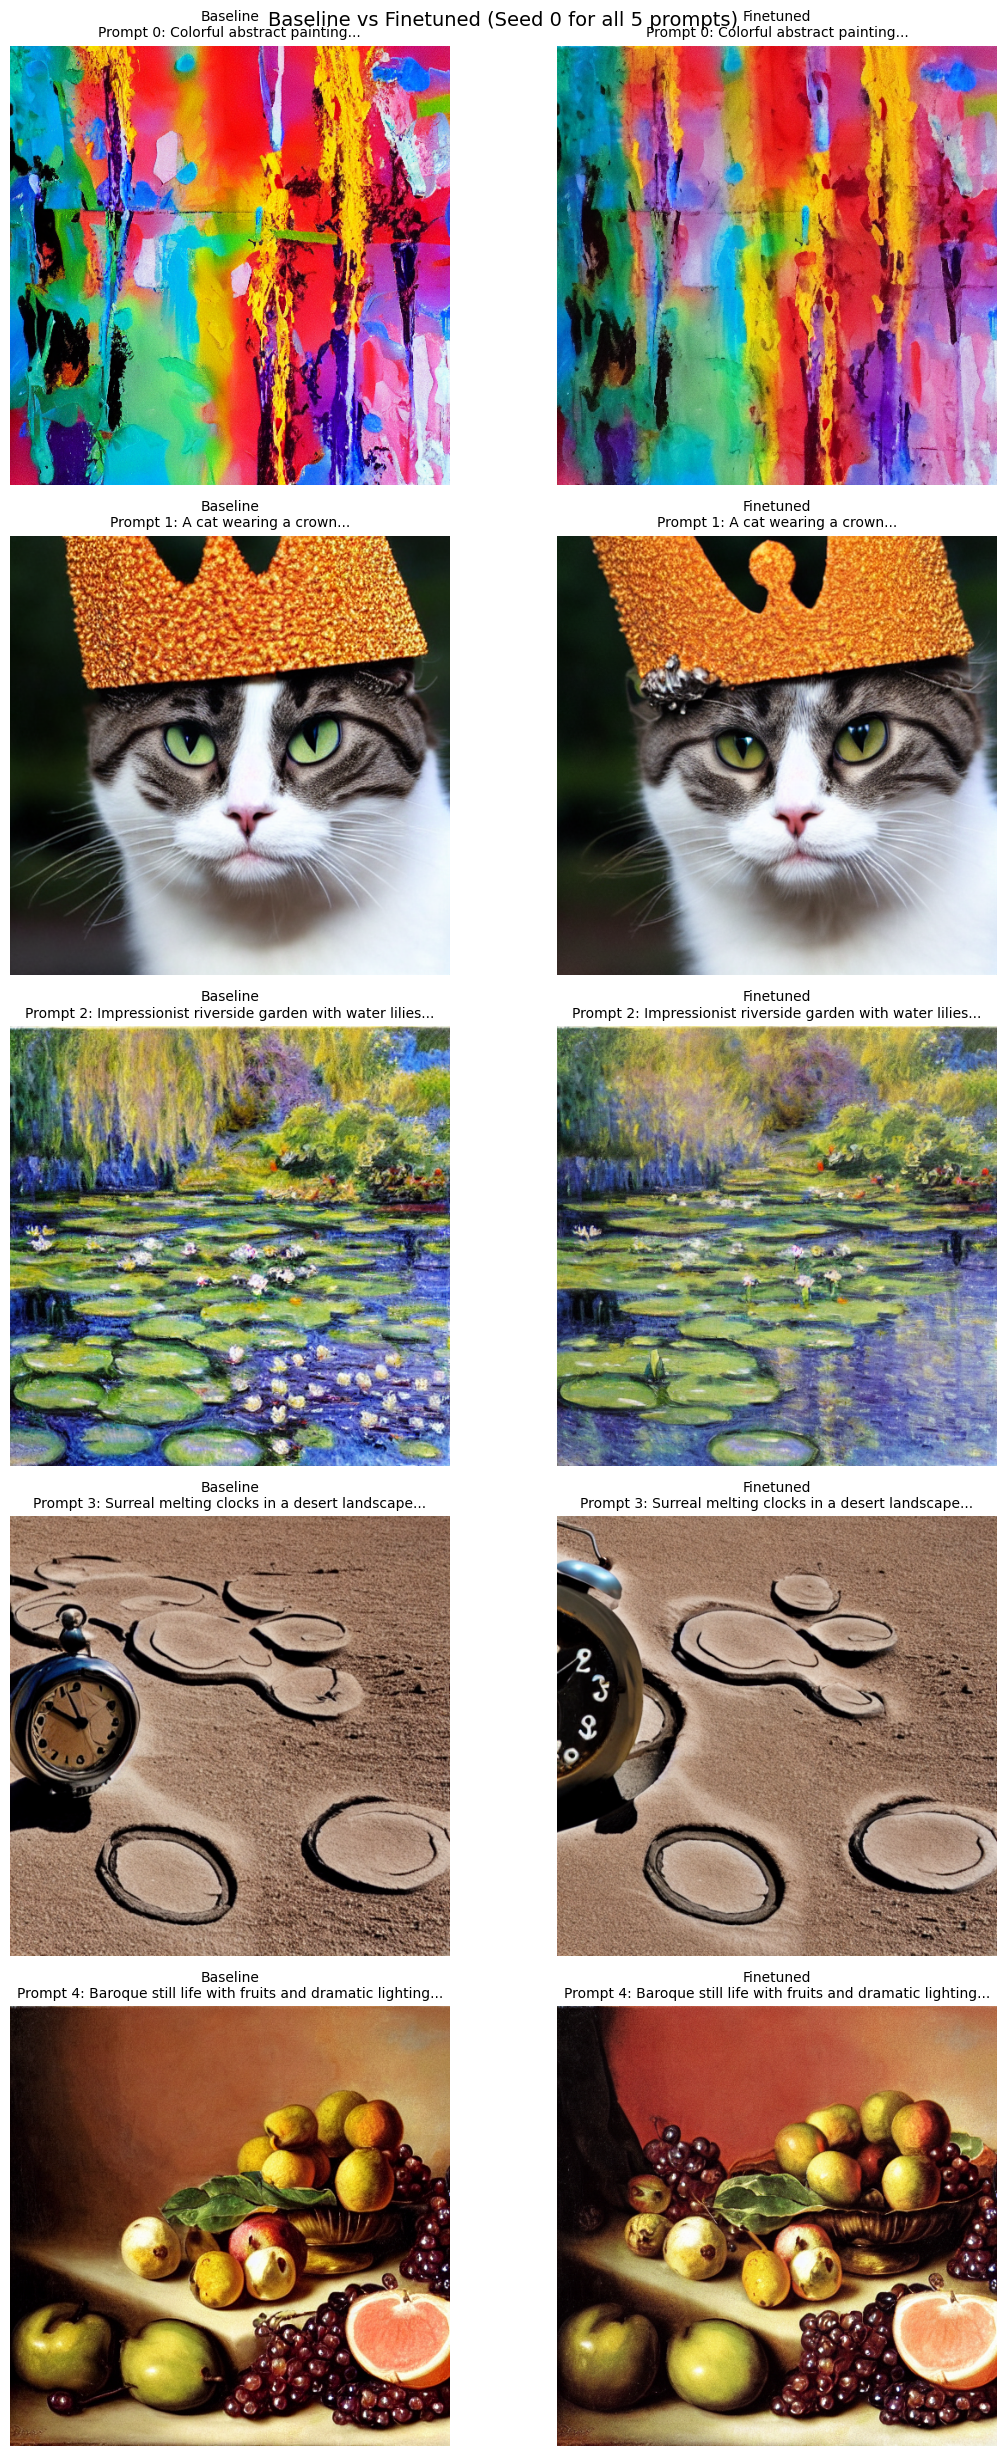

In [ ]:
# ============================
# Visualize all 5 prompts: Baseline vs Finetuned (side-by-side)
# ============================
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

# Load directories
base_dir = Path(cfg.output_dir) / "eval_generations" / "baseline_pretrained"
ft_dir   = Path(cfg.output_dir) / "eval_generations" / "finetuned_lora"

# Choose which seed to compare for all prompts (0–9)
seed_to_show = 0

plt.figure(figsize=(12, 5 * len(cfg.prompts)))
for i, prompt in enumerate(cfg.prompts):
    base_path = base_dir / f"baseline_p{i}_seed{seed_to_show}.png"
    ft_path   = ft_dir / f"finetuned_p{i}_seed{seed_to_show}.png"

    if not (base_path.exists() and ft_path.exists()):
        print(f"Missing files for prompt {i}, seed {seed_to_show}")
        continue

    base_img = Image.open(base_path)
    ft_img   = Image.open(ft_path)

    # baseline (left)
    plt.subplot(len(cfg.prompts), 2, 2*i + 1)
    plt.imshow(base_img)
    plt.axis("off")
    plt.title(f"Baseline\nPrompt {i}: {prompt[:60]}...", fontsize=10)

    # finetuned (right)
    plt.subplot(len(cfg.prompts), 2, 2*i + 2)
    plt.imshow(ft_img)
    plt.axis("off")
    plt.title(f"Finetuned\nPrompt {i}: {prompt[:60]}...", fontsize=10)

plt.suptitle("Baseline vs Finetuned (Seed 0 for all 5 prompts)", fontsize=14)
plt.tight_layout()
plt.show()
